## Vehicle Detection Project
---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

### Import Packages

In [1]:
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import pickle
import glob
import time
%matplotlib inline

print('...')

/home/jongkuk/miniconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jongkuk/miniconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jongkuk/miniconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jongkuk/miniconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jongkuk/miniconda3/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibili

...


### Load Training Data

In [2]:
car_images = glob.glob('dataset/vehicles/**/*.png')
noncar_images = glob.glob('dataset/non-vehicles/**/*.png')

print("The number of vehicle dataset: ", len(car_images))
print("The number of non-vehicle dataset: ", len(noncar_images))

The number of vehicle dataset:  8792
The number of non-vehicle dataset:  8968


### Visualize Some data

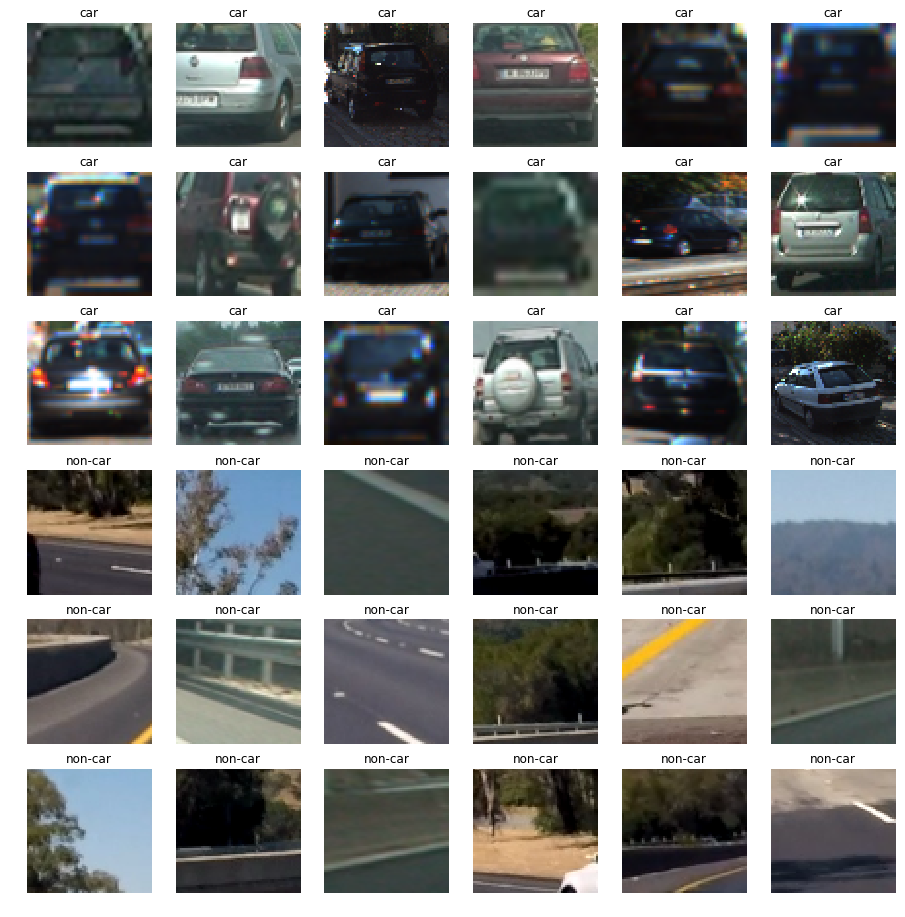

In [3]:
figure, axs = plt.subplots(6,6, figsize=(16,16))
# figure.subplots_adjust(hspace=.2, wspace=.001)
figure.subplots_adjust(hspace=.2, wspace=.001)
axs = axs.ravel() # change to a 1d array to handle simply

# visualize car images
for i in np.arange(18):
    random_index = np.random.randint(0, len(car_images))
    image = cv2.imread(car_images[random_index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=12)
    
# visualize noncar images
for i in np.arange(18,36):
    random_index = np.random.randint(0, len(noncar_images))
    image = cv2.imread(noncar_images[random_index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title('non-car', fontsize=12)
    

### Feature Extraction: Spatially Binned Features

In [4]:
# Define a function to compute binned color features
def bin_spatial(image, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    bin_features = cv2.resize(image, size).ravel()
    
    # Return the feature vector
    return bin_features
print(...)

Ellipsis


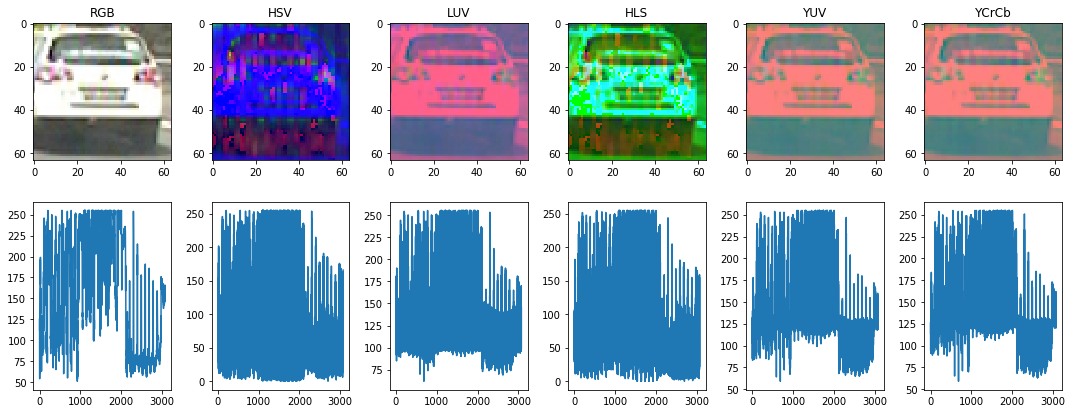

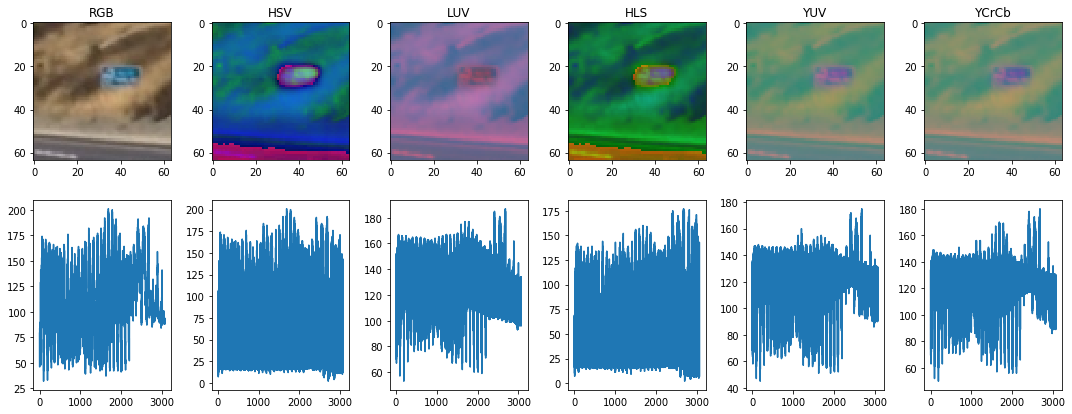

In [5]:
color_space = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'] # HSV, LUV, HLS, YUV, YCrCb

# car_image = mpimg.imread(car_images[777]) # scale [0..1] for floats or [0..255] for integers
car_image = cv2.imread(car_images[777]) # random number 777
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)

# noncar_image = mpimg.imread(noncar_images[777]) # scale [0..1] for floats or [0..255] for integers
noncar_image = cv2.imread(noncar_images[777]) # random number 777
noncar_image = cv2.cvtColor(noncar_image, cv2.COLOR_BGR2RGB)

i = 0
# visualize car images
fig1 = plt.figure(figsize=(15,6))
for color in color_space:
    # Apply color conversion if other than 'RGB'
    if color != 'RGB':
        if color == 'HSV':
            cvt_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2HSV)
        elif color == 'LUV':
            cvt_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2LUV)
        elif color == 'HLS':
            cvt_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2HLS)
        elif color == 'YUV':
            cvt_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YUV)
        elif color == 'YCrCb':
            cvt_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
    else:
        cvt_image = np.copy(car_image)
    
    feature_vec = bin_spatial(cvt_image, size=(32,32))
    
    ax1 = fig1.add_subplot(2, 6, i+1)
    plt.imshow(cvt_image)
    ax1.set_title(color, fontsize=12)
    
    ax2 = fig1.add_subplot(2, 6, i+7)
    plt.plot(feature_vec)
    ax1.set_title(color, fontsize=12)

    i += 1
    
fig1.subplots_adjust(bottom=0.1, hspace=.02, wspace=0.02)
fig1.tight_layout()



i = 0
# visualize noncar images
fig2 = plt.figure(figsize=(15,6))
for color in color_space:
    # Apply color conversion if other than 'RGB'
    if color != 'RGB':
        if color == 'HSV':
            cvt_image = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2HSV)
        elif color == 'LUV':
            cvt_image = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2LUV)
        elif color == 'HLS':
            cvt_image = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2HLS)
        elif color == 'YUV':
            cvt_image = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2YUV)
        elif color == 'YCrCb':
            cvt_image = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2YCrCb)
    else:
        cvt_image = np.copy(noncar_image)
    
    feature_vec = bin_spatial(cvt_image, size=(32,32))
    
    ax1 = fig2.add_subplot(2, 6, i+1)
    plt.imshow(cvt_image)
    ax1.set_title(color, fontsize=12)
    
    ax2 = fig2.add_subplot(2, 6, i+7)
    plt.plot(feature_vec)
    ax1.set_title(color, fontsize=12)

    i += 1
    
fig2.subplots_adjust(left=0.03, right=0.99, top=0.98, bottom=0.05, wspace=0.2, hspace=0.2)
fig2.tight_layout()

### Feature Extraction:  Color Histogram

In [6]:
# Define a function to compute color histogram features
def color_hist(image, nbins=32, bins_range=(0,256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
print("...")

...


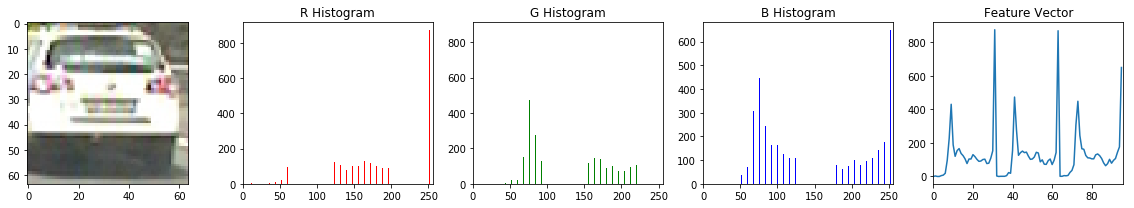

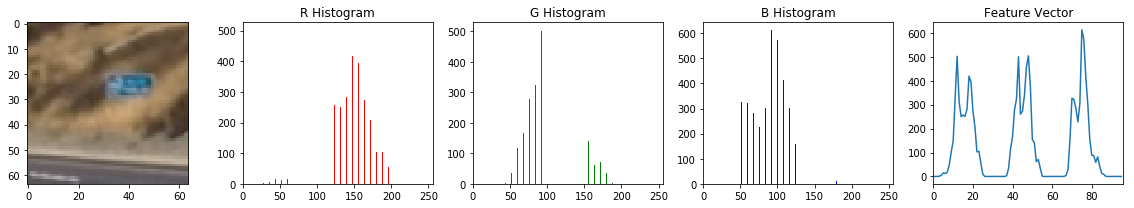

In [7]:
color_space = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'] # HSV, LUV, HLS, YUV, YCrCb

# Load car and noncar images
# car_image = mpimg.imread(car_images[777]) # scale [0..1] for floats or [0..255] for integers
car_image = cv2.imread(car_images[777]) # random number 777
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)

# noncar_image = mpimg.imread(noncar_images[777]) # scale [0..1] for floats or [0..255] for integers
noncar_image = cv2.imread(noncar_images[777]) # random number 777
noncar_image = cv2.cvtColor(noncar_image, cv2.COLOR_BGR2RGB)


### Car image visualization

# Take histograms in each channel
channel1_hist = np.histogram(car_image[:,:,0], bins=32, range=(0,256))
channel2_hist = np.histogram(car_image[:,:,1], bins=32, range=(0,256))
channel3_hist = np.histogram(car_image[:,:,2], bins=32, range=(0,256))

# Take a feature concatenated with each histogram
hist_features = color_hist(car_image, nbins=32, bins_range=(0,256))

# Generate bin centers
bin_edges = channel1_hist[1]
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2

# Plot a figure with all three bar charts
fig1 = plt.figure(figsize=(16,3))
plt.subplot(151)
plt.imshow(car_image)

plt.subplot(152)
plt.bar(bin_centers, channel1_hist[0], color='red')
plt.xlim(0,256)
plt.title('R Histogram')
plt.subplot(153)
plt.bar(bin_centers, channel2_hist[0], color='green')
plt.xlim(0,256)
plt.title('G Histogram')
plt.subplot(154)
plt.bar(bin_centers, channel3_hist[0], color='blue')
plt.xlim(0,256)
plt.title('B Histogram')

plt.subplot(155)
plt.plot(hist_features)
plt.xlim(0,len(hist_features))
plt.title('Feature Vector')

fig1.subplots_adjust(bottom=0.1, hspace=.02, wspace=0.02)
fig1.tight_layout()


### Non-car image visualization

# Take histograms in each channel
channel1_hist = np.histogram(noncar_image[:,:,0], bins=32, range=(0,256))
channel2_hist = np.histogram(noncar_image[:,:,1], bins=32, range=(0,256))
channel3_hist = np.histogram(noncar_image[:,:,2], bins=32, range=(0,256))

# Take a feature concatenated with each histogram
hist_features = color_hist(noncar_image, nbins=32, bins_range=(0,256))

# Generate bin centers
bin_edges = channel1_hist[1]
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2

# Plot a figure with all three bar charts
fig2 = plt.figure(figsize=(16,3))
plt.subplot(151)
plt.imshow(noncar_image)

plt.subplot(152)
plt.bar(bin_centers, channel1_hist[0], color='red')
plt.xlim(0,256)
plt.title('R Histogram')
plt.subplot(153)
plt.bar(bin_centers, channel2_hist[0], color='green')
plt.xlim(0,256)
plt.title('G Histogram')
plt.subplot(154)
plt.bar(bin_centers, channel3_hist[0], color='blue')
plt.xlim(0,256)
plt.title('B Histogram')

plt.subplot(155)
plt.plot(hist_features)
plt.xlim(0,len(hist_features))
plt.title('Feature Vector')

fig2.subplots_adjust(bottom=0.1, hspace=.02, wspace=0.02)
fig2.tight_layout()

### Convert Images to HOG(Histogram of Oriented Gradients) features
*The code for the method was used from the course material.*

In [8]:
def get_hog_features(image, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(image, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, visualize=vis, 
                                  feature_vector=feature_vec 
                                  #block_norm="L2-Hys"
                                 )
        return features, hog_image
    
    # Otherwise, call with one output
    else:
        features = hog(image, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell), 
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, visualize=vis, 
                       feature_vector=feature_vec
                       #block_norm="L2-Hys"
                      )
        return features

print('...')

...


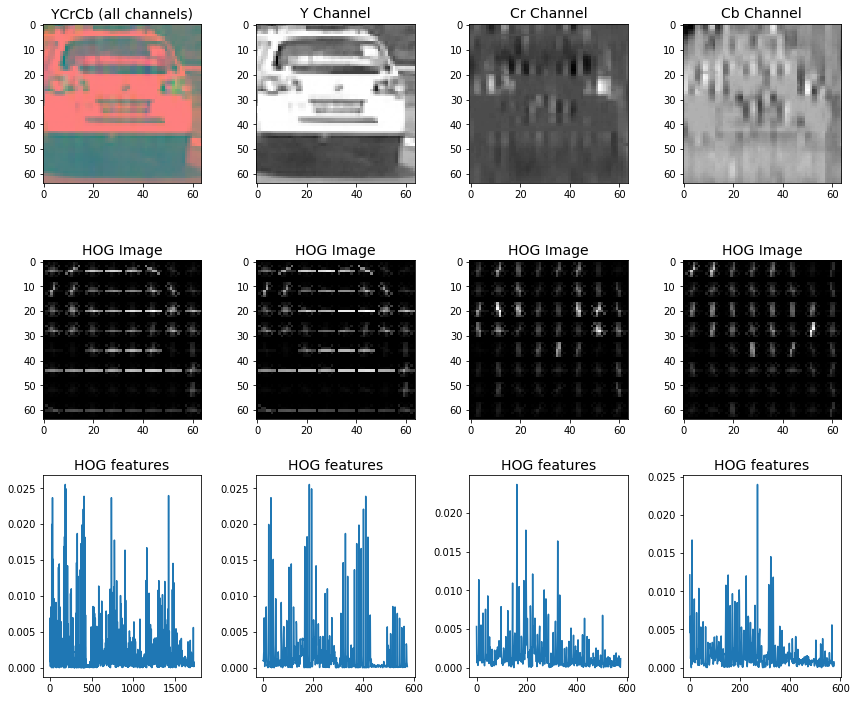

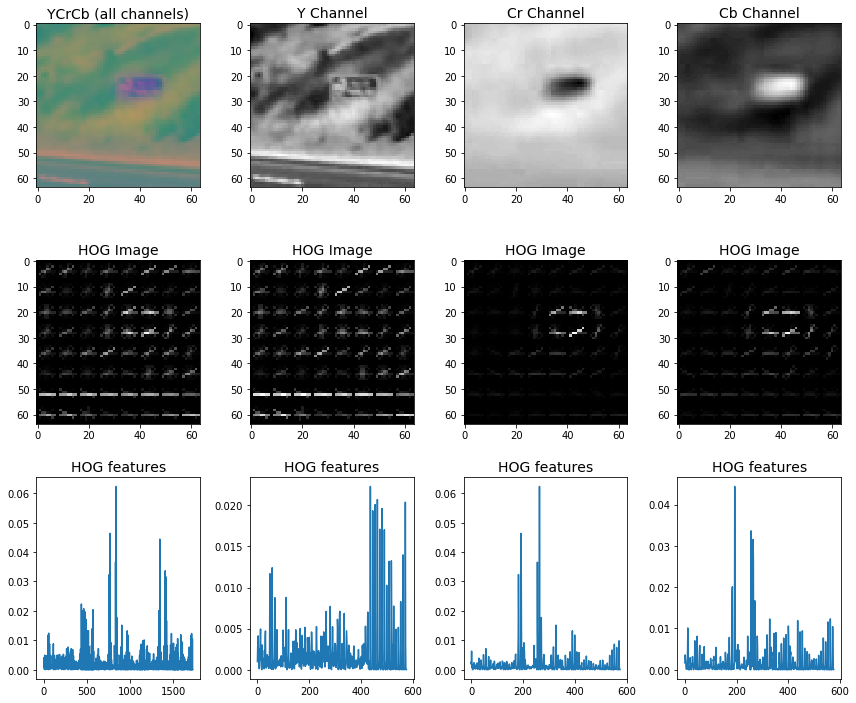

In [9]:
color_space = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'] # HSV, LUV, HLS, YUV, YCrCb
hog_channel = ['ALL', 0, 1, 2]
channel_name = ['Y', 'Cr', 'Cb']

car_image = mpimg.imread(car_images[777]) # scale [0..1] for floats or [0..255] for integers
# car_image = cv2.imread(car_images[5]) # random number 777
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)

noncar_image = mpimg.imread(noncar_images[777]) # scale [0..1] for floats or [0..255] for integers
# noncar_image = cv2.imread(noncar_images[777]) # random number 777
noncar_image = cv2.cvtColor(noncar_image, cv2.COLOR_BGR2RGB)


# car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2YCrCb)

i = 0
# visualize car images
fig1 = plt.figure(figsize=(12,10))
features2 = []
for channel in hog_channel:
    if channel == 'ALL':

        feature1, car_hog_image1 = get_hog_features(car_image[:, :, 0], orient=9, pix_per_cell=8, cell_per_block=8, vis=True, feature_vec=True)
        
        feature2, car_hog_image2 = get_hog_features(car_image[:, :, 1], orient=9, pix_per_cell=8, cell_per_block=8, vis=True, feature_vec=True)

        feature3, car_hog_image3 = get_hog_features(car_image[:, :, 2], orient=9, pix_per_cell=8, cell_per_block=8, vis=True, feature_vec=True)
        
        features = np.hstack((feature1, feature2, feature3))
        
#         car_hog_images = np.dstack([car_hog_image1, car_hog_image2, car_hog_image3])
        car_hog_images = car_hog_image1 + car_hog_image2 + car_hog_image3
        
#         features, car_hog_images = get_hog_features(car_image, orient=9, pix_per_cell=8, cell_per_block=8, vis=True, feature_vec=True)        

    else:
        features, car_hog_images = get_hog_features(car_image[:, :, channel], orient=9, pix_per_cell=8, cell_per_block=8, vis=True, feature_vec=True)
    
    if channel == 'ALL':
        ax1 = fig1.add_subplot(3, 4, i+1)
        plt.imshow(car_image)
        ax1.set_title("YCrCb (all channels)", fontsize=14)
        
        ax2 = fig1.add_subplot(3, 4, i+5)
        plt.imshow(car_hog_images, cmap='gray')
        ax2.set_title('HOG Image', fontsize=14)
    
        ax3 = fig1.add_subplot(3, 4, i+9)
        plt.plot(features)
        ax3.set_title('HOG features', fontsize=14)
    
    else:
        ax1 = fig1.add_subplot(3, 4, i+1)
        plt.imshow(car_image[:,:,channel], cmap='gray')
        ax1.set_title("{} Channel".format(channel_name[i-1]), fontsize=14)
        
        ax2 = fig1.add_subplot(3, 4, i+5)
        plt.imshow(car_hog_images, cmap='gray')
        ax2.set_title('HOG Image', fontsize=14)
    
        ax3 = fig1.add_subplot(3, 4, i+9)
        plt.plot(features)
        ax3.set_title('HOG features', fontsize=14)

    i += 1
    
fig1.subplots_adjust(bottom=0.1, hspace=.02, wspace=0.02)
fig1.tight_layout()





# noncar_image = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2YCrCb)
noncar_image = cv2.cvtColor(noncar_image, cv2.COLOR_BGR2YCrCb)

i = 0
# visualize car images
fig2 = plt.figure(figsize=(12,10))
for channel in hog_channel:
    if channel == 'ALL':

        feature1, noncar_hog_image1 = get_hog_features(noncar_image[:, :, 0], orient=9, pix_per_cell=8, cell_per_block=8, vis=True, feature_vec=True)

        feature2, noncar_hog_image2 = get_hog_features(noncar_image[:, :, 1], orient=9, pix_per_cell=8, cell_per_block=8, vis=True, feature_vec=True)

        feature3, noncar_hog_image3 = get_hog_features(noncar_image[:, :, 2], orient=9, pix_per_cell=8, cell_per_block=8, vis=True, feature_vec=True)
        
        features = np.hstack((feature1, feature2, feature3))
        
#         noncar_hog_images = np.dstack([noncar_hog_image1, noncar_hog_image2, noncar_hog_image3])
        noncar_hog_images = noncar_hog_image1 + noncar_hog_image2 + noncar_hog_image3     

    else:
        features, noncar_hog_images = get_hog_features(noncar_image[:, :, channel], orient=9, pix_per_cell=8, cell_per_block=8, vis=True, feature_vec=True)
    
    if channel == 'ALL':
        ax1 = fig2.add_subplot(3, 4, i+1)
        plt.imshow(noncar_image)
        ax1.set_title("YCrCb (all channels)", fontsize=14)
        
        ax2 = fig2.add_subplot(3, 4, i+5)
        plt.imshow(noncar_hog_images, cmap='gray')
        ax2.set_title('HOG Image', fontsize=14)
    
        ax3 = fig2.add_subplot(3, 4, i+9)
        plt.plot(features)
        ax3.set_title('HOG features', fontsize=14)
    
    else:
        ax1 = fig2.add_subplot(3, 4, i+1)
        plt.imshow(noncar_image[:,:,channel], cmap='gray')
        ax1.set_title("{} Channel".format(channel_name[i-1]), fontsize=14)
        
        ax2 = fig2.add_subplot(3, 4, i+5)
        plt.imshow(noncar_hog_images, cmap='gray')
        ax2.set_title('HOG Image', fontsize=14)
    
        ax3 = fig2.add_subplot(3, 4, i+9)
        plt.plot(features)
        ax3.set_title('HOG features', fontsize=14)

    i += 1
    
fig2.subplots_adjust(bottom=0.1, hspace=.02, wspace=0.02)
fig2.tight_layout()

### Visualize HOG Features on Example Images

In [10]:
# # HOG featured image for car
# car_image = mpimg.imread(car_images[777]) # random number 777
# _, car_hog_image = get_hog_features(car_image[:, :, 2], orient=9, pix_per_cell=8, cell_per_block=8, vis=True, feature_vec=True)

# # HOG featured image for non-car
# noncar_image = mpimg.imread(noncar_images[777])
# _, noncar_hog_image = get_hog_features(noncar_image[:, :, 2], orient=9, pix_per_cell=8, cell_per_block=8, vis=True, feature_vec=True)

# # Visualize HOG featured images
# figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(7,7))
# figure.subplots_adjust(hspace=.4, wspace=.2)
# ax1.imshow(car_image)
# ax1.axis('off')
# ax1.set_title('Car', fontsize=15)
# ax2.imshow(car_hog_image, cmap='gray')
# ax2.axis('off')
# ax2.set_title('Car HOG', fontsize=15)
# ax3.imshow(noncar_image)
# ax3.axis('off')
# ax3.set_title('Non-Car', fontsize=15)
# ax4.imshow(noncar_hog_image, cmap='gray')
# ax4.axis('off')
# ax4.set_title('Non-Car HOG', fontsize=15)

### Features Extraction from an Array of Car and Non-Car Images
*The code for the method was used from the course material.*

In [11]:
# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons)
# to extract flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification

def extract_features(images, color_space='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for path in images:
        
        # Read in each one by one
        image =mpimg.imread(path)
        
        # Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
            
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)

        # Apply get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_feature = get_hog_features(feature_image[:, :, channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True) # type: list
                hog_features.append(hog_feature) # type: list
            hog_features = np.ravel(hog_features) # type: ndarray (change a list to 1d ndarray)
        
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
#         # Append the new feature vector to the features list (hog only)
#         features.append(hog_features)
        # Append the new feature vector to the features list (hog+spatial+colorhistogram)
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        
    # Return list of feature vectors
    return features

print("...")

...


In [12]:
# just for test.
# little confused about data type. check this out
a = np.array([1,2,3])
print("a: ", a)
print("a.type: ",type(a))
a2 = []
a2.append(a)
print("a2: ", a2)
print("a2.type: ", type(a2))
a3 = np.ravel(a2)
print("a3: ", a3)
print("type(a3): ", type(a3))

a:  [1 2 3]
a.type:  <class 'numpy.ndarray'>
a2:  [array([1, 2, 3])]
a2.type:  <class 'list'>
a3:  [1 2 3]
type(a3):  <class 'numpy.ndarray'>


### Extract Features for Input Datasets and Combine, Define Labels Vector, Shuffle and Split

In [13]:
# Feature extraction parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins = 64
orient = 12 #11
pix_per_cell = 16 #8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or 'ALL'

t = time.time()
# car_features = extract_features(car_images, color_space=color_space, orient=orient, 
#                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
# notcar_features = extract_features(noncar_images, color_space=color_space, orient=orient, 
#                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

car_features = extract_features(car_images, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=(0, 256),
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(noncar_images, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=(0, 256),
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()
print(round(t2 - t, 2), "seconds to extract HOG features...")

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler 
# This will be necessary if combining different types(scale) of features (HOG + color_hist + bin_spatial)
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print("Using:", color_space,"Colorspace,", orient, 'orientations,', pix_per_cell, 'pixels/cell, ', cell_per_block, 'cells/block')
print("Feature vector length: ", len(X_train[0]))

38.47 seconds to extract HOG features...
Using: YCrCb Colorspace, 12 orientations, 16 pixels/cell,  2 cells/block
Feature vector length:  4560


**Parameter exploration**

| Configuration Label | Colorspace | Orientations | Pixels Per Cell | Cells Per Block | HOG Channel | Extract Time |
| :-----------------: | :--------: | :----------: | :-------------: | :-------------: | :---------: | ------------:|
| 1                   | RGB        | 9            | 8               | 2               | ALL         | 71.16        |
| 2                   | HSV        | 9            | 8               | 2               | 1           | 43.74        |
| 3                   | HSV        | 9            | 8               | 2               | 2           | 36.35        |
| 4                   | LUV        | 9            | 8               | 2               | 0           | 37.42        |
| 5                   | LUV        | 9            | 8               | 2               | 1           | 38.34        |
| 6                   | HLS        | 9            | 8               | 2               | 0           | 37.42        |
| 7                   | HLS        | 9            | 8               | 2               | 1           | 42.04        |
| 8                   | YUV        | 9            | 8               | 2               | 0           | 35.86        |
| 9                   | YCrCb      | 9            | 8               | 2               | 1           | 38.32        |
| 10                  | YCrCb      | 9            | 8               | 2               | 2           | 38.99        |
| 11                  | HSV        | 9            | 8               | 2               | ALL         | 79.72        |
| 12                  | LUV        | 9            | 8               | 2               | ALL         | 78.57        |
| 13                  | HLS        | 9            | 8               | 2               | ALL         | 81.37        |
| 14                  | YUV        | 9            | 8               | 2               | ALL         | 81.82        |
| 15                  | YCrCb      | 9            | 8               | 2               | ALL         | 79.05        |
| 16                  | YUV        | 9            | 8               | 1               | 0           | 44.04        |
| 17                  | YUV        | 9            | 8               | 3               | 0           | 37.74        |
| 18                  | YUV        | 6            | 8               | 2               | 0           | 37.12        |
| 19                  | YUV        | 12           | 8               | 2               | 0           | 40.11        |
| 20                  | YUV        | 11           | 8               | 2               | 0           | 38.01        |
| 21                  | YUV        | 11           | 16              | 2               | 0           | 30.21        |
| 22                  | YUV        | 11           | 12              | 2               | 0           | 30.33        |
| 23                  | YUV        | 11           | 4               | 2               | 0           | 69.08        |
| 24                  | YUV        | 11           | 16              | 2               | ALL         | 55.20        |
| 25                  | YUV        | 7            | 16              | 2               | ALL         | 53.18        |


### Train a Classifier

In [14]:
# Use a linear SVC
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'seconds to train SVM Classifier.')
print("...")

# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 4)
print("Test Accuracy of SVM =", svc_score)
print("...")

# Check the prediction time for a single sample
n_predict = 10
t = time.time()
svc_predict = svc.predict(X_test[0:n_predict])
print("For these TRUE Labels: ", y_test[0:n_predict])
print("The SVM Classifier prediction result:  ", svc_predict)
t2 = time.time()
print(round(t2 - t, 6), "seconds to predict", n_predict, "labels with the SVM Classifier.")

7.39 seconds to train SVM Classifier.
...
Test Accuracy of SVM = 0.9834
...
For these TRUE Labels:  [1. 1. 1. 0. 1. 0. 0. 1. 1. 1.]
The SVM Classifier prediction result:   [1. 1. 1. 0. 1. 0. 0. 1. 1. 1.]
0.000644 seconds to predict 10 labels with the SVM Classifier.


### Method for Using Classifier to Detect Cars in an Image

In [15]:
# Define a single function that can extract features using hog sub-sampling and make predictions

def find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient,
             pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # arrays of rectangles where cars were detected
    rectangles = []
    image = image.astype(np.float32)/255
    image_tosearch = image[ystart:ystop , : , :]
    
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
            if color_space == 'HSV':
                color_transform_tosearch = cv2.cvtColor(image_tosearch, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                color_transform_tosearch = cv2.cvtColor(image_tosearch, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                color_transform_tosearch = cv2.cvtColor(image_tosearch, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                color_transform_tosearch = cv2.cvtColor(image_tosearch, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                color_transform_tosearch = cv2.cvtColor(image_tosearch, cv2.COLOR_RGB2YCrCb)
    else:
        color_transform_tosearch = np.copy(image)

    # Rescale image if other than 1.0 scale
    if scale != 1:
        image_shape = color_transform_tosearch.shape
        color_transform_tosearch = cv2.resize(color_transform_tosearch, (np.int(image_shape[1]/scale), np.int(image_shape[0]/scale)))
    
    # Select color space channel for HOG
    if hog_channel == 'ALL':
        ch1 = color_transform_tosearch[:, :, 0]
        ch2 = color_transform_tosearch[:, :, 1]
        ch3 = color_transform_tosearch[:, :, 2]
    else:
        ch1 = color_transform_tosearch[:,:,hog_channel]
        
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // (cells_per_step +2) + 1
    
    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch (즉! 위에서 이미지 전체에 대해 HOG Feature를 뽑았고, 여기서는 윈도우 크기만큼 분할해서 준다.)
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window , xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window , xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window , xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window , xpos:xpos+nblocks_per_window].ravel()
                hog_features = hog_feat1
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
#          ############# IN CASE OF USING OTHER FEATURE EXTRACTION ###########
            # Extract the image patch
            subimg = cv2.resize(color_transform_tosearch[ytop:ytop+window , xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
#             test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)

#          ##############################################################
            # only use hog features
#             test_prediction = svc.predict(hog_features.reshape(1,-1))
            ##############################################################
    
            if (test_prediction == 1) or show_all_rectangles:
#             if test_prediction == 1:
#             print("test_prediction: ", test_prediction)
#             print("show_all_rectangles: ", show_all_rectangles)
#             print("test_prediction ==1 or show_all_rectangles: ", test_prediction ==1 or show_all_rectangles)
        
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                
            
#     # visualize images
#     fig1 = plt.figure(figsize=(20,5))
#     plt.imshow(image_tosearch)
#     plt.title('ROI Image', fontsize=20)
    
#     fig2 = plt.figure(figsize=(20,5))
#     plt.imshow(color_transform_tosearch)
#     plt.title('Scaled down YCrCb Image', fontsize=20)
            
#     _, car_hog_image = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
#     fig3 = plt.figure(figsize=(20,5))
#     plt.imshow(car_hog_image, cmap='gray')
#     plt.title('HOG features (ALL Channels)', fontsize=20)

    return rectangles

print("...")


...


### Test find_cars() on an Example Image

In [16]:
test_image = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins = 64
orient = 12 #11
pix_per_cell = 16 #16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or 'ALL'

rectangles = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# rectangles = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')


6 rectangles found in image


### Method to Draw Rectangles onto an Image

In [17]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(image, bboxes, color=(0,0,255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(image)
    random_color = False
    
    #Iterate through the bounding boxes
    for bbox in bboxes:
        # for random color bboxes, select the color
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    # Return the image copy with boxes drawn
    return imcopy
    
print("...")

...


...


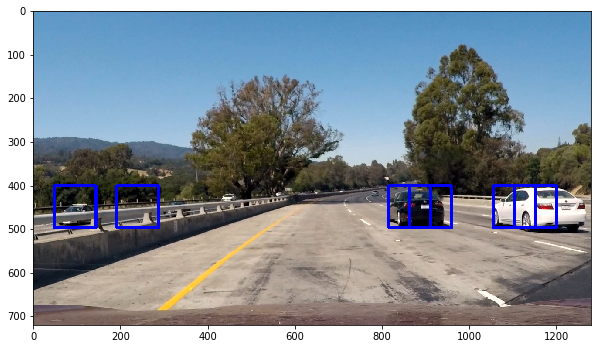

In [18]:
test_image_rectangles = draw_boxes(test_image, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_image_rectangles)
print("...")

### Show All Potential Search Areas

Depending on the distance from the camera, the size and position of cars in the image are all different.

So, the function `find_cars()` should be called a few more times with various `ystart`, `ystop`, and `scale` values.

The next few cells are for determining the best values for these parameters.

Number of boxes:  78


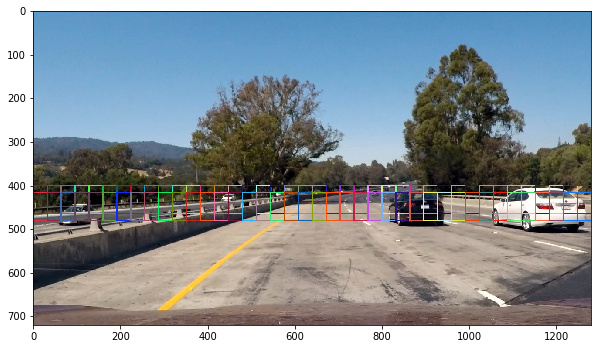

In [19]:
test_image = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0
rectangle1 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
# rectangle1 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True)
rects.append(rectangle1)

ystart = 416
ystop = 480
scale = 1.0

rectangle2 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                       X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
# rectangle2 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True)
rects.append(rectangle2)

# make a right form to call 'draw_boxes()' 
# it's a way to flatten a list of lists
# ex: [[(( , ))]] => [((, ))]
rectangles = []
for sublist in rects:
    for item in sublist:
        rectangles.append(item)
# print('rectangles: ', rectangles)

test_image_rectangle = draw_boxes(test_image, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_image_rectangle)
print("Number of boxes: ", len(rectangles))

Number of boxes:  50


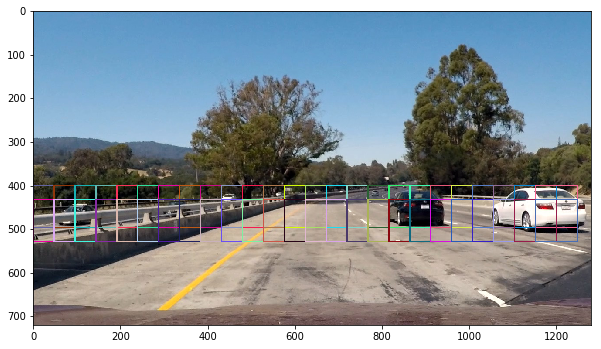

In [20]:
test_image = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 496
scale = 1.5

rectangle1 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
# rectangle1 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True)
rects.append(rectangle1)

ystart = 432
ystop = 528
scale = 1.5

rectangle2 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
# rectangle2 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True)
rects.append(rectangle2)

# make a right form to call 'draw_boxes()' 
# it's a way to flatten a list of lists
# ex: [[(( , ))]] => [((, ))]
rectangles = []
for sublist in rects:
    for item in sublist:
        rectangles.append(item)
# print('rectangles: ', rectangles)

test_image_rectangle = draw_boxes(test_image, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_image_rectangle)
print("Number of boxes: ", len(rectangles))

Number of boxes:  38


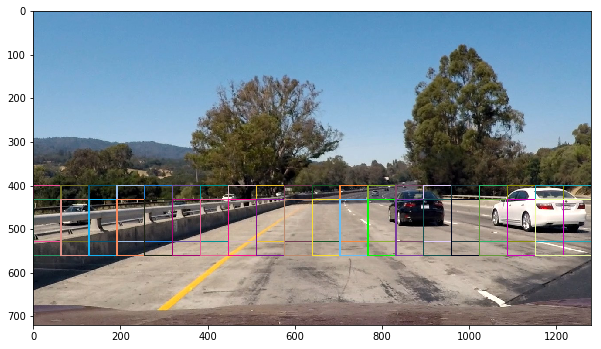

In [21]:
test_image = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 528
scale = 2.0

rectangle1 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
# rectangle1 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True)
rects.append(rectangle1)

ystart = 432
ystop = 560
scale = 2.0

rectangle2 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
# rectangle2 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True)
rects.append(rectangle2)

# make a right form to call 'draw_boxes()' 
# it's a way to flatten a list of lists
# ex: [[(( , ))]] => [((, ))]
rectangles = []
for sublist in rects:
    for item in sublist:
        rectangles.append(item)
# print('rectangles: ', rectangles)

test_image_rectangle = draw_boxes(test_image, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_image_rectangle)
print("Number of boxes: ", len(rectangles))

Number of boxes:  30


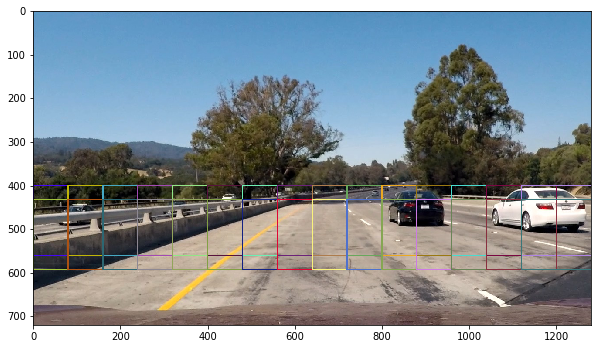

In [22]:
test_image = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 560
scale = 2.5

rectangle1 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
# rectangle1 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True)
rects.append(rectangle1)

ystart = 432
ystop = 592
scale = 2.5

rectangle2 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
# rectangle2 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True)
rects.append(rectangle2)

# make a right form to call 'draw_boxes()' 
# it's a way to flatten a list of lists
# ex: [[(( , ))]] => [((, ))]
rectangles = []
for sublist in rects:
    for item in sublist:
        rectangles.append(item)
# print('rectangles: ', rectangles)

test_image_rectangle = draw_boxes(test_image, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_image_rectangle)
print("Number of boxes: ", len(rectangles))

Number of boxes:  24


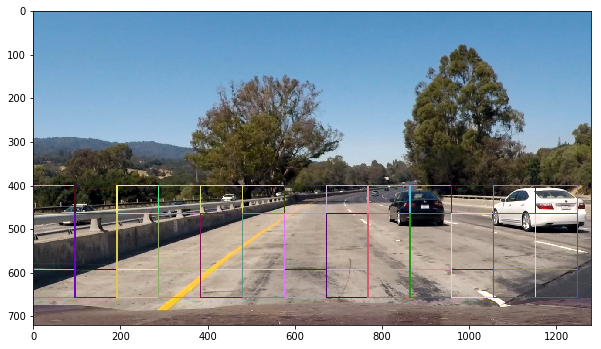

In [23]:
test_image = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 592
scale = 3.0

rectangle1 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
# rectangle1 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True)
rects.append(rectangle1)

ystart = 464
ystop = 660
scale = 3.0

rectangle2 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=True)
# rectangle2 = find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True)
rects.append(rectangle2)

# make a right form to call 'draw_boxes()' 
# it's a way to flatten a list of lists
# ex: [[(( , ))]] => [((, ))]
rectangles = []
for sublist in rects:
    for item in sublist:
        rectangles.append(item)
# print('rectangles: ', rectangles)

test_image_rectangle = draw_boxes(test_image, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_image_rectangle)
print("Number of boxes: ", len(rectangles))

### Combine Various Sliding Window Searches

Number of boxes:  15


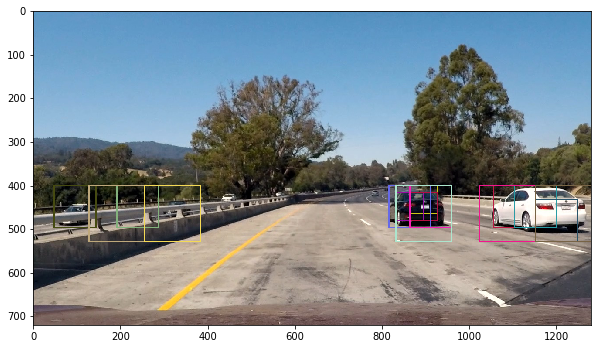

In [24]:
test_image = mpimg.imread('./test_images/test1.jpg')

rectangles = []

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins = 64
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
orient = 12 #11
pix_per_cell = 16 #16
cell_per_block = 2


ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
# rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None))

ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
# rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None))

ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
# rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None))

ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
# rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None))

ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
# rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None))

ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
# rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None))

ystart = 400
ystop = 596
scale = 3.5
rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
# rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None))

ystart = 464
ystop = 660
scale = 3.5
rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
# rectangles.append(find_cars(test_image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                       orient, pix_per_cell, cell_per_block, None, None))

# print("rectangles: ", rectangles)

# I got to know this way from other's work, and I find this is the simplest way to flatten a list of lists.
# It's needed for making a right form for 'draw_boxes()''
rectangles = [item for sublist in rectangles for item in sublist] 
# print("rectangles: ", rectangles)

test_image_rectangle = draw_boxes(test_image, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_image_rectangle)
print("Number of boxes: ", len(rectangles))


### Heatmap
This method is excerpted from the lesson material.

It produces a heat map based on rectangle locations to combine overlapped rectangle and reject the false positive

In [25]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1] , box[0][0]:box[1][0]] += 1
        
    # Return updated heatmap
    return heatmap

print("...")

...


...


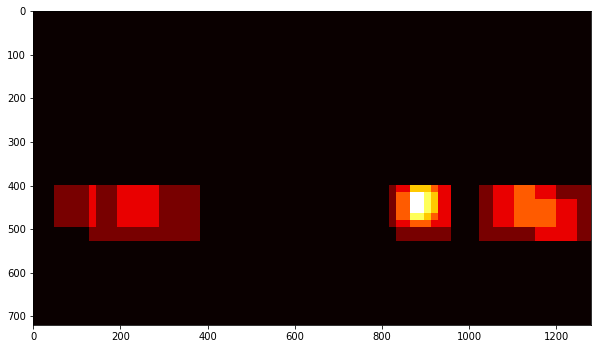

In [26]:
# Test out the heatmap
heatmap_image = np.zeros_like(test_image[:,:,0])
heatmap_image = add_heat(heatmap_image, rectangles)

'''
#just for check
#be careful with dimensions

print("rectangles: ", rectangles)
print("rectangles[0]: ", rectangles[0])
print("rectangles[0][0]: ", rectangles[0][0])
print("rectangles[0][0][0]: ", rectangles[0][0][0])
print("rectangles[0][0][0]: ", rectangles[0][1][0])
print("rectangles[0][0][1]: ", rectangles[0][0][1])
print("rectangles[0][1][1]: ", rectangles[0][1][1])
'''

plt.figure(figsize=(10,10))
plt.imshow(heatmap_image, cmap='hot')

print('...')

### Apply a Threshold to the Heatmap

In [27]:
def apply_threshold(heatmap, threshold=1):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

print("...")

...


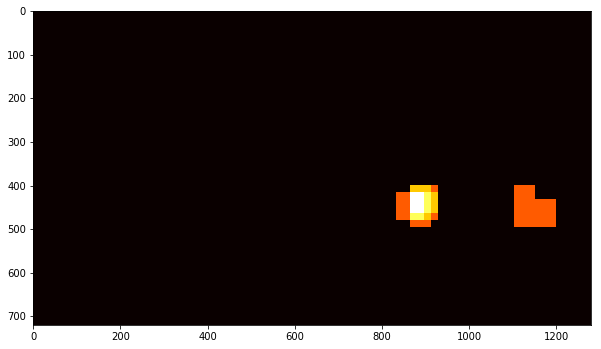

In [28]:
threshold = 2
heatmap_image = apply_threshold(heatmap_image, threshold)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_image, cmap='hot')

### Apply Scipy Labels to heatmap

Total 2 cars found


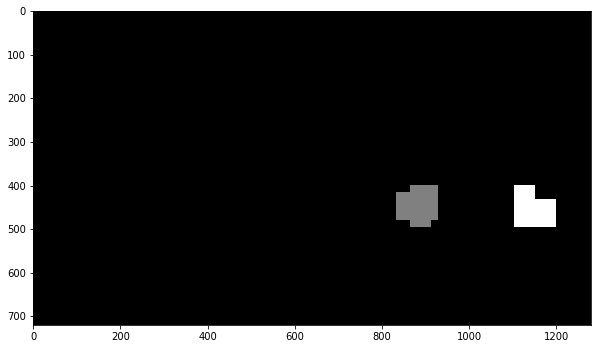

In [29]:
labels = label(heatmap_image) # return (labeled heat map image , the number of labels)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')

print("Total", labels[1], "cars found")

### Draw Final Bounding Boxes for Labels

In [30]:
def draw_labeled_bboxes(image, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a final bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        
        # Draw the box on the image
        cv2.rectangle(image, bbox[0], bbox[1], (0,0,255), 6)
    
    # Return the image and final rectangles
    return image, rects

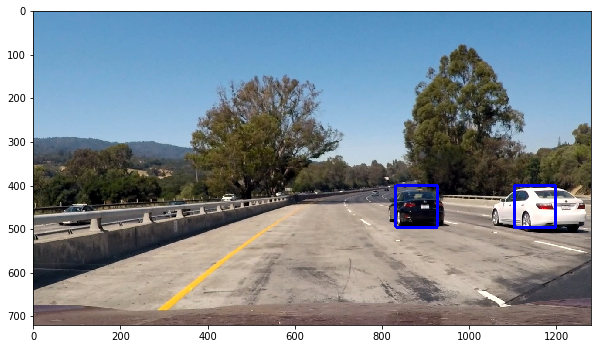

In [31]:
# Draw bounding boxes on a copy of the image
draw_image, rect = draw_labeled_bboxes(np.copy(test_image), labels)

# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_image)

### Put it All in a Unified Pipeline

In [32]:
def process_frame(image):
    
    rectangles = []
    
    color_space = 'YCrCb' # Canbe RGB, HSV, LUV, HLS, YUV, YCrCb
    spatial_size = (32, 32)
    hist_bins = 64
    orient = 12#11
    pix_per_cell = 16#16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    threshold = 1
    
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    
    rectangles = [item for sublist in rectangles for item in sublist] 
#     print("rectangles: ", len(rectangles))
    heatmap_image = np.zeros_like(image[:,:,0])
    heatmap_image = add_heat(heatmap_image, rectangles)
    heatmap_image = apply_threshold(heatmap_image, threshold)
    labels = label(heatmap_image)
    draw_image, rects = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_image

print("...")    

...


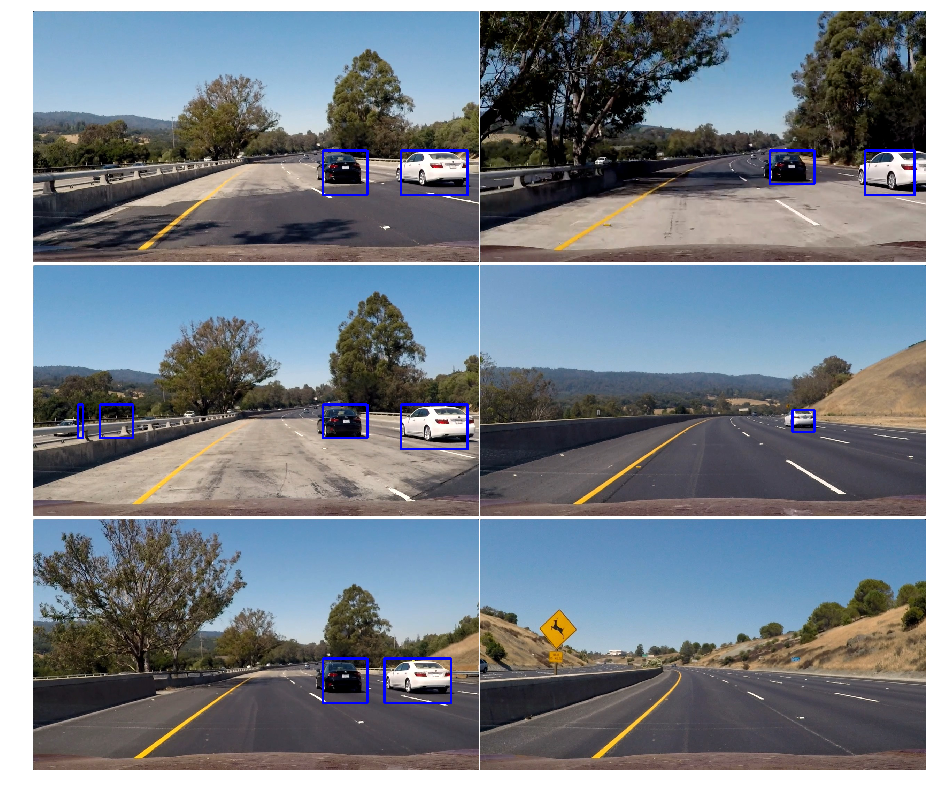

In [33]:
test_images = glob.glob('./test_images/test*.jpg')

figure, axs = plt.subplots(3, 2, figsize=(16,14))
figure.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for index, image in enumerate(test_images):
    axs[index].imshow(process_frame(mpimg.imread(image)))
    axs[index].axis('off')

### Run a Video Through the Piepeline (weak version)
It only processes a frame at a time without consideration of previous frames

In [34]:
# 1) test video
video_output = 'test_video_output.mp4'
video_input = VideoFileClip('test_video.mp4')#.subclip(10,15)
processed_video = video_input.fl_image(process_frame)
%time processed_video.write_videofile(video_output, audio=False)

# 2) project video
# video_output = 'project_video_output.mp4'
# video_input = VideoFileClip('project_video.mp4')#.subclip(10,15)
# processed_video = video_input.fl_image(process_frame)
# %time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:12<00:00,  3.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 1min 31s, sys: 1.66 s, total: 1min 32s
Wall time: 13 s


In [35]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(video_output))

### Define a Class to Store Data from Vehicle Detections

In [36]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rectangles = []
        
    def add_rectangles(self, rectangles):
        self.prev_rectangles.append(rectangles)
        if len(self.prev_rectangles) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rectangles = self.prev_rectangles[len(self.prev_rectangles)-15 : ]
            
print("...")

...


In [37]:
def process_frame_for_video(image):
    
    rectangles = []
    
    color_space = 'YCrCb' # Canbe RGB, HSV, LUV, HLS, YUV, YCrCb
    spatial_size = (32, 32)
    hist_bins = 64
    orient = 12#11
    pix_per_cell = 16#16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
#     rectangles.append(find_cars(image, ystart, ystop, scale, color_space, hog_channel, svc, None, 
#                           orient, pix_per_cell, cell_per_block, None, None))

    
    rectangles = [item for sublist in rectangles for item in sublist] 
#     print("rectangles: ", len(rectangles))
    
    if len(rectangles) > 0:
        detection.add_rectangles(rectangles)
    
    heatmap_image = np.zeros_like(image[:,:,0])
    for rectangle_set in detection.prev_rectangles:
            heatmap_image = add_heat(heatmap_image, rectangle_set)
            
    heatmap_image = apply_threshold(heatmap_image, 1 + len(detection.prev_rectangles)//2)
    
    labels = label(heatmap_image)
    draw_image, rects = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_image

print("...")    

...


### Run a Video Through the Pipeline (modified)
It processes each frame with information from previous frames

In [38]:
detection = Vehicle_Detect()

# 1) test video2
# video_output2 = 'test_video_output2.mp4'
# video_input2 = VideoFileClip('test_video.mp4')
# processed_video2 = video_input2.fl_image(process_frame_for_video)
# %time processed_video2.write_videofile(video_output2, audio=False)

# 2) project video2
video_output2 = 'project_video_output2.mp4'
video_input2 = VideoFileClip('project_video.mp4')#.subclip(0,30)
processed_video2 = video_input2.fl_image(process_frame_for_video)
%time processed_video2.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


100%|█████████▉| 1260/1261 [07:07<00:00,  2.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output2.mp4 

CPU times: user 52min 1s, sys: 52.9 s, total: 52min 54s
Wall time: 7min 8s


In [39]:
# HTML("""
# <video width="960" height='540' controls>
#   <source src="{0}">
# </video
# """.format(video_output2))